# Exponent Comparisons

This notebook compares methods that directly estimate aperiodic exponents.  

Compared methods:
- spectral parameterization
- IRASA

ToDo:
- This notebook is incomplete, and will be fleshed out when the full IRASA explorations are integrated, and can be compared directly to specparam here

In [1]:
import numpy as np
from scipy.stats import ttest_rel

from neurodsp.sim import sim_combined
from neurodsp.utils import set_random_seed

from bootstrap import bootstrap_corr

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.run import run_comparisons
from apm.core.db import APMDB
from apm.plts import plot_dots
from apm.plts.errors import plot_violin_errors
from apm.utils import format_corr, sampler
from apm.methods import irasa, specparam
from apm.methods.settings import IRASA_PARAMS
from apm.sim.settings import FS, SIM_PARAMS_COMB

/Users/tom/Code/Projects/APMethods/AperiodicMethods/apm/plts/data.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.utils import trim_spectrum


## Settings

In [3]:
# Define measure settings
f_range = [1, 50]
specparam_params = {'min_peak_height' : 0.05, 'fs' : FS, 'f_range' : f_range}

In [4]:
# Define run settings
RETURN_SIM_PARAMS = True

In [5]:
# Settings for saving figures
SAVE_FIG = True
EXT = '.pdf'
FIGPATH = APMDB().figs_path / '21_exp_exp_comp'

In [6]:
# Set the random seed
set_random_seed(111)

## Collect Methods

In [7]:
# Define ranges to sample parameters from
samplers = {'update_comb_exp' : sampler(np.arange(-2.5, 0, 0.1)),
            'update_pow' : sampler(np.arange(0, 1, 0.1)),
            'update_freq' : sampler(np.arange(5, 35, 1))}

In [8]:
# Define measures to apply
measures = {specparam : specparam_params,
            irasa : IRASA_PARAMS}

## Run Simulations

In [9]:
N_SIMS = 1000

In [10]:
# Run simulations, comparing SpecParam & IRASA, sampling oscillation power
outputs, sim_params = run_comparisons(\
    sim_combined, SIM_PARAMS_COMB, measures, samplers, N_SIMS, RETURN_SIM_PARAMS)

In [11]:
# Get the simualated exponent values
sim_exps = -sim_params.exponent.values

### Errors

In [12]:
# Calculate errors of each method, as compared to ground truth simulations
errors = {}
for method in outputs.keys():
    errors[method] = np.abs(outputs[method] - sim_exps)

In [13]:
# Check the errors per method
for method in errors.keys():
    print('{:10s}\t{:1.4f}'.format(method, np.mean(errors[method])))

specparam 	0.0392
irasa     	0.0243


In [14]:
# Check the statistical difference between measure errors
ttest_rel(errors['specparam'], errors['irasa'])

TtestResult(statistic=14.175034797638176, pvalue=1.0771197967711976e-41, df=999)

### Visualize

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


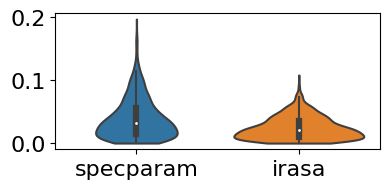

In [15]:
# Plot the errors 
plot_violin_errors(errors, figsize=(4, 2))

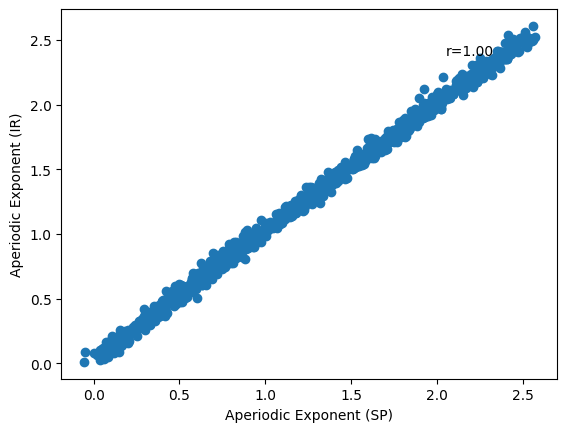

In [16]:
# Plot the comparison between specparam and IRASA
plot_dots(outputs['specparam'], outputs['irasa'], 
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          save_fig=SAVE_FIG, file_name='spec_irasa_exp' + EXT, file_path=FIGPATH)

In [17]:
# Check correlations
corrs = bootstrap_corr(outputs['specparam'], outputs['irasa'])
print('  SP & IR:  ', format_corr(*corrs))

  SP & IR:   r=+0.998  CI[+0.998, +0.998],  p=0.000


## Conclusions

Comparing between these methods, overall we can see that:
- In simple cases (powerlaw + oscillations), specparam and IRASA perform very similarly